# 기본환경 세팅 확인

In [1]:
!nvidia-smi

Wed Sep 11 13:15:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   57C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## CPU 대비 GPU에서 TensorFlow 속도 향상 관찰
- 이 예제는 일반적인 컨볼루션 신경망 계층을 구성되어 있음.
- 무작위 이미지를 생성하고 CPU 또는 GPU에 수동으로 결과 ops를 배치합니다
- 실행 속도를 비교합니다.

In [3]:
import tensorflow as tf
import timeit

# GPU 디바이스 이름을 가져옵니다.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':  # GPU가 없는 경우 오류 메시지 출력
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')  # 시스템 오류 발생

# CPU에서 실행할 함수 정의
def cpu():
  with tf.device('/cpu:0'):  # CPU 디바이스 사용
    random_image_cpu = tf.random.normal((100, 100, 100, 3))  # 무작위 이미지 생성
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)  # Conv2D 레이어 적용
    return tf.math.reduce_sum(net_cpu)  # 결과의 합 계산

# GPU에서 실행할 함수 정의
def gpu():
  with tf.device('/device:GPU:0'):  # GPU 디바이스 사용
    random_image_gpu = tf.random.normal((100, 100, 100, 3))  # 무작위 이미지 생성
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)  # Conv2D 레이어 적용
    return tf.math.reduce_sum(net_gpu)  # 결과의 합 계산

# 각 연산을 한 번씩 실행하여 워밍업을 수행합니다.
cpu()
gpu()

# 연산을 여러 번 실행하여 성능을 측정합니다.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')

# CPU 성능 측정
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)

# GPU 성능 측정
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)

# GPU의 CPU 대비 성능 향상 비율 계산 및 출력
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.35615882999999826
GPU (s):
0.07394835499999886
GPU speedup over CPU: 4x


## Tensorflow 버전 확인
- 2024년 7월 기준 (2.17.0)

In [4]:
import tensorflow as tf
print(tf.__version__)

2.17.0


# XOR 문제

## 경사 하강법 설명
1. 함수 정의
  - `gradient_descent`라는 이름의 함수를 정의합니다. 이 함수는 입력 데이터(X), 출력 데이터(y), 학습률(learning_rate), 반복 횟수(n_iterations)를 인자로 받습니다.

2. 샘플 수 확인
  - `m = len(X)`는 입력 데이터의 샘플 수를 변수 m에 저장합니다. 이는 데이터의 총 개수를 의미합니다.

3. 바이어스 항 추가
  - $X_b$ = `np.c_[np.ones((X.shape[0], 1)), X]`는 입력 데이터에 바이어스 항(즉, 항상 1인 추가 열)을 추가합니다. 바이어스 항은 모델이 더 유연하게 동작하도록 돕습니다.

4. 가중치 초기화
  - `theta = np.random.randn(X_b.shape[1], 1)`는 가중치 `theta`를 임의의 값으로 초기화합니다. 이는 모델이 학습할 때 조정할 값들입니다.

5. loss_history 초기화
  - `loss_history = []`는 손실 값을 저장할 빈 리스트를 초기화합니다. 이 리스트는 모델이 학습하면서 손실이 어떻게 변하는지 기록하는 데 사용됩니다.

6. 경사 하강법 반복 : `주어진 반복 횟수(`n_iterations`)만큼 다음 과정을 반복
  - `z = X_b.dot(theta)`는 현재 가중치를 사용하여 예측 값을 계산
  - `y_pred = sigmoid(z)`는 예측 값을 시그모이드 함수에 통과시켜 최종 예측 값을 얻습니다. 시그모이드 함수는 예측 값을 0과 1 사이의 값으로 변환
  - `gradients = X_b.T.dot(y_pred - y) / len(y)`는 예측 값과 실제 값의 차이를 사용하여 그래디언트를 계산합니다. 그래디언트는 손실 함수의 기울기이며, 가중치를 어떻게 조정할지 알려줍니다.
  - `theta = theta - learning_rate * gradients`는 학습률(`learning_rate`)을 사용하여 가중치를 업데이트 합니다.
  - `loss = compute_loss(y, y_pred)`  현재 예측 값과 실제 값 사이의 손실을 계산
  - `loss_history.append(loss)`는 계산된 손실 값을 손실 히스토리에 추가

## 비유를 통해 이해하기
- 이 과정을 산을 내려가는 것에 비유할 수 있습니다. 산 꼭대기에서 시작하여 가장 낮은 지점을 찾기 위해 아래로 내려가는 과정입니다.

  + `가중치 초기화`는 산 꼭대기에서 출발점을 정하는 것과 같습니다.

  + `손실 함수`는 우리가 얼마나 높은 지점에 있는지 알려주는 도구입니다.

  + `그래디언트`는 현재 위치에서 가장 가파르게 내려갈 방향을 가리킵니다.

  + `학습률`은 한 걸음에 얼마나 많이 내려갈지 결정합니다.

  + `반복`은 여러 번 걸음을 옮기면서 계속해서 산을 내려가는 과정입니다.

  + `결과 반환`은 우리가 최종적으로 도달한 위치와 그동안의 여정을 기록한 것입니다.



## 결과 비교
- AND 네트워크는 학습을 진행할수록 손실함수의 값이 줄어듬
- XOR 네트워크는 학습을 진행해도 손실함수의 값은 줄어들지 않음

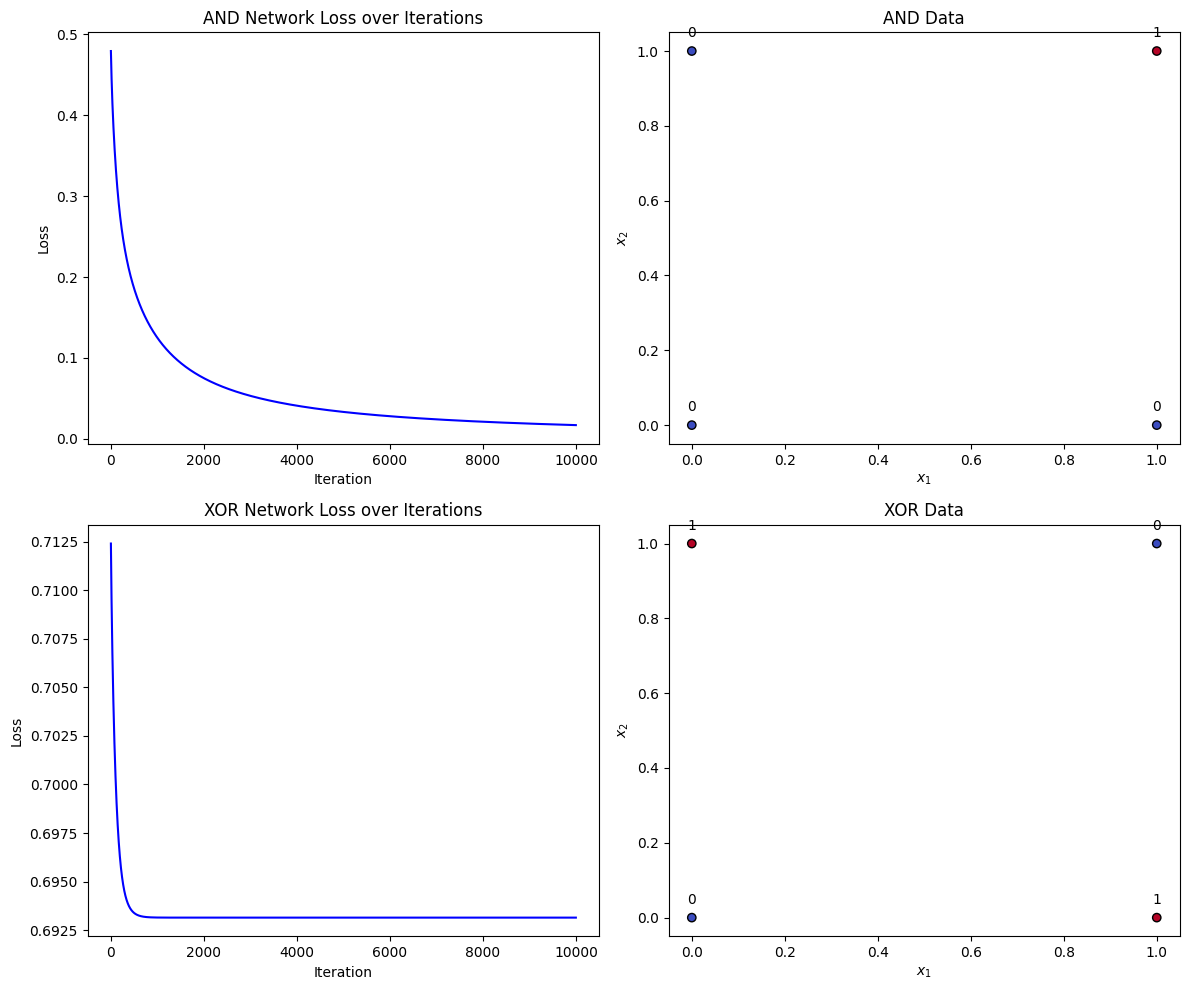

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# AND 데이터셋 정의
X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([[0], [0], [0], [1]])

# XOR 데이터셋 정의
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

# 경사 하강법을 수행하고 손실을 계산하는 함수 정의
def gradient_descent(X, y, learning_rate=0.1, n_iterations=10000):
    m = len(X)  # 샘플 수
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # 바이어스 항 추가
    theta = np.random.randn(X_b.shape[1], 1)  # 가중치를 임의의 값으로 초기화
    loss_history = []  # 손실 히스토리 초기화

    for iteration in range(n_iterations):
        z = X_b.dot(theta)  # 선형 모델의 출력 계산
        y_pred = sigmoid(z)  # 예측 값 계산
        gradients = X_b.T.dot(y_pred - y) / len(y)  # 그래디언트 계산
        theta = theta - learning_rate * gradients  # 가중치 업데이트
        loss = compute_loss(y, y_pred)  # 손실 계산
        loss_history.append(loss)  # 손실 히스토리에 추가

    return theta, loss_history  # 가중치와 손실 히스토리 반환

# 시그모이드 함수 정의
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 이진 교차 엔트로피 손실 함수 정의
def compute_loss(y_true, y_pred):
    m = len(y_true)
    return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# AND와 XOR 데이터셋에 대해 경사 하강법 수행
theta_and, loss_history_and = gradient_descent(X_and, y_and)
theta_xor, loss_history_xor = gradient_descent(X_xor, y_xor)

# 손실 및 데이터셋 플롯
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# AND 네트워크의 손실 변화를 플롯
ax[0, 0].plot(range(len(loss_history_and)), loss_history_and, color='blue')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_title('AND Network Loss over Iterations')

# AND 데이터셋 플롯
ax[0, 1].scatter(X_and[:, 0], X_and[:, 1], c=y_and.ravel(), edgecolors='k', marker='o', cmap='coolwarm')
for i, txt in enumerate(y_and.ravel()):
    ax[0, 1].annotate(txt, (X_and[i, 0], X_and[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
ax[0, 1].set_xlabel('$x_1$')
ax[0, 1].set_ylabel('$x_2$')
ax[0, 1].set_title('AND Data')

# XOR 네트워크의 손실 변화를 플롯
ax[1, 0].plot(range(len(loss_history_xor)), loss_history_xor, color='blue')
ax[1, 0].set_xlabel('Iteration')
ax[1, 0].set_ylabel('Loss')
ax[1, 0].set_title('XOR Network Loss over Iterations')

# XOR 데이터셋 플롯
ax[1, 1].scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor.ravel(), edgecolors='k', marker='o', cmap='coolwarm')
for i, txt in enumerate(y_xor.ravel()):
    ax[1, 1].annotate(txt, (X_xor[i, 0], X_xor[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
ax[1, 1].set_xlabel('$x_1$')
ax[1, 1].set_ylabel('$x_2$')
ax[1, 1].set_title('XOR Data')

plt.tight_layout()  # 플롯 레이아웃 조정
plt.show()  # 플롯 표시


# MLP without backpropagation

In [6]:
import numpy as np

# 간단한 데이터셋 생성
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([[0],
              [1],
              [1],
              [0]])

# MLP 파라미터
input_size = 2
hidden_size = 2
output_size = 1

# 가중치와 바이어스 초기화
np.random.seed(42)  # 재현성을 위해 시드 설정

# W1과 b1는 입력층과 은닉층 사이의 가중치와 바이어스입니다.
# W2와 b2는 은닉층과 출력층 사이의 가중치와 바이어스입니다.
W1 = np.random.randn(input_size, hidden_size)
b1 = np.random.randn(hidden_size)
W2 = np.random.randn(hidden_size, output_size)
b2 = np.random.randn(output_size)

# 활성화 함수 (히든 레이어에 ReLU, 출력 레이어에 sigmoid 사용)
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward_pass(X, W1, b1, W2, b2):
  """
  하나의 은닉층을 가진 단순 다층 퍼셉트론(MLP)을 통해 순전파를 수행합니다.

  매개변수:
  X (numpy.ndarray): 입력 데이터로, 형태는 (샘플 수, 특징 수)입니다.
  W1 (numpy.ndarray): 입력층에서 은닉층으로의 가중치 행렬로, 형태는 (특징 수, 은닉층 뉴런 수)입니다.
  b1 (numpy.ndarray): 은닉층의 바이어스 벡터로, 형태는 (은닉층 뉴런 수,)입니다.
  W2 (numpy.ndarray): 은닉층에서 출력층으로의 가중치 행렬로, 형태는 (은닉층 뉴런 수, 출력층 뉴런 수)입니다.
  b2 (numpy.ndarray): 출력층의 바이어스 벡터로, 형태는 (출력층 뉴런 수,)입니다.

  반환값:
  numpy.ndarray: 순전파 후 MLP의 출력으로, 형태는 (샘플 수, 출력층 뉴런 수)입니다.
  """
  z1 = np.dot(X, W1) + b1  # 입력층에서 은닉층으로의 선형 변환
  a1 = relu(z1)  # 은닉층 활성화 함수 적용

  z2 = np.dot(a1, W2) + b2  # 은닉층에서 출력층으로의 선형 변환
  a2 = sigmoid(z2)  # 출력층 활성화 함수 적용

  return a2


# 순전파 수행
output = forward_pass(X, W1, b1, W2, b2)

# 결과 출력
print("Output of MLP forward pass:")
print(output)

Output of MLP forward pass:
[[0.38474066]
 [0.76363755]
 [0.48629467]
 [0.86424862]]


# 후진 모드 자동 미분
- 이 코드에서는 `Variable` 클래스를 통해 값과 로컬 그래디언트를 저장하고, 덧셈과 곱셈 연산을 정의하여 자동 미분을 수행합니다. 주요 함수와 클래스는 다음과 같습니다.

1. **Variable 클래스**
   - 변수의 값과 로컬 그래디언트를 저장합니다.
   - 덧셈 (`__add__`)과 곱셈 (`__mul__`) 연산을 지원합니다.

2. **add 함수**
   - 두 변수의 덧셈을 수행하고 로컬 그래디언트를 계산합니다.

3. **mul 함수**
   - 두 변수의 곱셈을 수행하고 로컬 그래디언트를 계산합니다.

4. **get_gradients 함수**
   - 주어진 변수에 대한 그래디언트를 계산합니다.
   - 내부적으로 `compute_gradients` 함수를 사용하여 그래디언트를 재귀적으로 계산합니다.

In [7]:
from collections import defaultdict

class Variable:
  def __init__(self, value, local_gradients=()):
      """
      Variable 클래스는 값과 로컬 그래디언트를 저장합니다.

      매개변수:
      value (float): 변수의 값.
      local_gradients (tuple): 로컬 그래디언트의 튜플.
      """
      self.value = value
      self.local_gradients = local_gradients

  def __add__(self, other):
      """
      변수의 덧셈 연산을 정의합니다.

      매개변수:
      other (Variable): 더할 다른 변수.

      반환값:
      Variable: 결과 변수.
      """
      return add(self, other)

  def __mul__(self, other):
      """
      변수의 곱셈 연산을 정의합니다.

      매개변수:
      other (Variable): 곱할 다른 변수.

      반환값:
      Variable: 결과 변수.
      """
      return mul(self, other)

def add(a, b):
  """
  두 변수의 덧셈을 수행하고 로컬 그래디언트를 계산합니다.

  매개변수:
  a (Variable): 첫 번째 변수.
  b (Variable): 두 번째 변수.

  반환값:
  Variable: 결과 변수.
  """
  value = a.value + b.value
  local_gradients = (
      (a, 1),
      (b, 1)
  )
  return Variable(value, local_gradients)

def mul(a, b):
  """
  두 변수의 곱셈을 수행하고 로컬 그래디언트를 계산합니다.

  매개변수:
  a (Variable): 첫 번째 변수.
  b (Variable): 두 번째 변수.

  반환값:
  Variable: 결과 변수.
  """
  value = a.value * b.value
  local_gradients = (
      (a, b.value),
      (b, a.value)
  )
  return Variable(value, local_gradients)

def get_gradients(variable):
  """
  변수의 그래디언트를 계산합니다.

  매개변수:
  variable (Variable): 그래디언트를 계산할 변수.

  반환값:
  dict: 변수에 대한 그래디언트 딕셔너리.
  """
  gradients = defaultdict(lambda: 0)

  def compute_gradients(variable, path_value):
      """
      변수에 대한 그래디언트를 재귀적으로 계산합니다.

      매개변수:
      variable (Variable): 그래디언트를 계산할 현재 변수.
      path_value (float): 현재 변수까지의 경로 값.

      설명:
      이 함수는 변수의 로컬 그래디언트를 사용하여 모든 자식 변수에 대한 그래디언트를 재귀적으로 계산합니다.
      로컬 그래디언트를 통해 자식 변수에 대한 경로 값을 업데이트하고,
      이를 다시 자식 변수의 그래디언트 계산에 사용합니다.
      """
      for child_variable, local_gradient in variable.local_gradients:
          value_of_path_to_child = path_value * local_gradient  # 자식 변수에 대한 경로 값 계산
          gradients[child_variable] += value_of_path_to_child  # 자식 변수의 그래디언트 업데이트
          compute_gradients(child_variable, value_of_path_to_child)  # 자식 변수에 대해 재귀적으로 그래디언트 계산

  compute_gradients(variable, path_value=1)  # 초기 경로 값 1로 시작
  return gradients

## 예제 사용법
- 다음은 예제 사용법입니다:

1. 변수 `a`와 `b`를 생성합니다.
2. `a`와 `b`를 더한 결과를 `c`에 저장합니다.
3. `a`와 `c`를 곱한 결과를 `d`에 저장합니다.
4. `d`에 대한 그래디언트를 계산하고 출력합니다.

- 출력 결과는 `d`의 값과 각 변수 (`a`, `b`, `c`)에 대한 `d`의 그래디언트를 보여줍니다.

In [8]:
# 예제 사용법:
a = Variable(4)
b = Variable(3)
c = add(a, b) # = 4 + 3 = 7
d = mul(a, c) # = 4 * 7 = 28

gradients = get_gradients(d)

print('d.value =', d.value)
print("The partial derivative of d with respect to a =", gradients[a])
print('gradients[b] =', gradients[b])
print('gradients[c] =', gradients[c])

d.value = 28
The partial derivative of d with respect to a = 11
gradients[b] = 4
gradients[c] = 4


# 역전파 적용

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# AND 데이터셋 정의
X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([[0], [0], [0], [1]])

# XOR 데이터셋 정의
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

# 경사 하강법을 수행하고 손실을 계산하는 함수 정의
def gradient_descent(X, y, learning_rate=0.1, n_iterations=10000):
    """
    주어진 데이터셋에 대해 경사 하강법을 수행하여 가중치를 업데이트하고 손실을 계산합니다.

    매개변수:
    X (numpy.ndarray): 입력 데이터.
    y (numpy.ndarray): 출력 데이터.
    learning_rate (float): 학습률.
    n_iterations (int): 반복 횟수.

    반환값:
    tuple: 최종 가중치 (theta)와 손실 히스토리 (loss_history).
    """
    m = len(X)
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # 바이어스 항 추가
    theta = np.random.randn(X_b.shape[1], 1)  # 가중치를 임의의 값으로 초기화
    loss_history = []

    for iteration in range(n_iterations):
        z = X_b.dot(theta)  # 예측 값 계산
        y_pred = sigmoid(z)  # 시그모이드 함수 적용
        gradients = X_b.T.dot(y_pred - y) / len(y)  # 그래디언트 계산
        theta = theta - learning_rate * gradients  # 가중치 업데이트
        loss = compute_loss(y, y_pred)  # 손실 계산
        loss_history.append(loss)  # 손실 히스토리 기록

    return theta, loss_history

# 시그모이드 함수 정의
def sigmoid(z):
    """
    시그모이드 활성화 함수를 적용합니다.

    매개변수:
    z (numpy.ndarray): 입력 값.

    반환값:
    numpy.ndarray: 시그모이드 함수가 적용된 값.
    """
    return 1 / (1 + np.exp(-z))

# 이진 교차 엔트로피 손실 함수 정의
def compute_loss(y_true, y_pred):
    """
    이진 교차 엔트로피 손실을 계산합니다.

    매개변수:
    y_true (numpy.ndarray): 실제 값.
    y_pred (numpy.ndarray): 예측 값.

    반환값:
    float: 이진 교차 엔트로피 손실 값.
    """
    m = len(y_true)
    return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# 단순 신경망 클래스 정의
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        단순 신경망을 초기화합니다.

        매개변수:
        input_size (int): 입력층의 뉴런 수.
        hidden_size (int): 은닉층의 뉴런 수.
        output_size (int): 출력층의 뉴런 수.
        """
        self.W1 = np.random.randn(input_size, hidden_size)  # 입력층에서 은닉층으로의 가중치 초기화
        self.b1 = np.random.randn(hidden_size)  # 은닉층의 바이어스 초기화
        self.W2 = np.random.randn(hidden_size, output_size)  # 은닉층에서 출력층으로의 가중치 초기화
        self.b2 = np.random.randn(output_size)  # 출력층의 바이어스 초기화

    def forward(self, X):
        """
        순전파를 수행합니다.

        매개변수:
        X (numpy.ndarray): 입력 데이터.

        반환값:
        numpy.ndarray: 출력 데이터.
        """
        self.Z1 = np.dot(X, self.W1) + self.b1  # 입력층에서 은닉층으로의 선형 변환
        self.A1 = sigmoid(self.Z1)  # 은닉층 활성화 함수 적용
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # 은닉층에서 출력층으로의 선형 변환
        self.A2 = sigmoid(self.Z2)  # 출력층 활성화 함수 적용
        return self.A2

    def backward(self, X, y, y_pred, learning_rate):
        """
        역전파를 수행하여 가중치와 바이어스를 업데이트합니다.

        매개변수:
        X (numpy.ndarray): 입력 데이터.
        y (numpy.ndarray): 실제 값.
        y_pred (numpy.ndarray): 예측 값.
        learning_rate (float): 학습률.
        """
        m = len(y)
        dZ2 = y_pred - y  # 출력층의 그래디언트 계산
        dW2 = np.dot(self.A1.T, dZ2) / m  # 은닉층에서 출력층으로의 가중치 그래디언트 계산
        db2 = np.sum(dZ2, axis=0) / m  # 출력층의 바이어스 그래디언트 계산
        dZ1 = np.dot(dZ2, self.W2.T) * self.A1 * (1 - self.A1)  # 은닉층의 그래디언트 계산
        dW1 = np.dot(X.T, dZ1) / m  # 입력층에서 은닉층으로의 가중치 그래디언트 계산
        db1 = np.sum(dZ1, axis=0) / m  # 은닉층의 바이어스 그래디언트 계산

        self.W1 -= learning_rate * dW1  # 가중치 업데이트
        self.b1 -= learning_rate * db1  # 바이어스 업데이트
        self.W2 -= learning_rate * dW2  # 가중치 업데이트
        self.b2 -= learning_rate * db2  # 바이어스 업데이트

    def train(self, X, y, learning_rate=0.1, n_iterations=10000):
        """
        주어진 데이터셋에 대해 신경망을 학습합니다.

        매개변수:
        X (numpy.ndarray): 입력 데이터.
        y (numpy.ndarray): 실제 값.
        learning_rate (float): 학습률.
        n_iterations (int): 반복 횟수.

        반환값:
        list: 손실 히스토리.
        """
        loss_history = []
        for iteration in range(n_iterations):
            y_pred = self.forward(X)  # 순전파 수행
            loss = compute_loss(y, y_pred)  # 손실 계산
            loss_history.append(loss)  # 손실 히스토리 기록
            self.backward(X, y, y_pred, learning_rate)  # 역전파 수행
        return loss_history

# XOR 데이터셋에 대해 로지스틱 회귀 경사 하강법 수행
theta_xor, loss_history_xor = gradient_descent(X_xor, y_xor)

# XOR 데이터셋에 대해 신경망 초기화 및 학습
nn_xor = SimpleNeuralNetwork(input_size=2, hidden_size=2, output_size=1)
loss_history_xor_nn = nn_xor.train(X_xor, y_xor)

# AND 데이터셋에 대해 경사 하강법 수행
theta_and, loss_history_and = gradient_descent(X_and, y_and)


- 역전파 적용

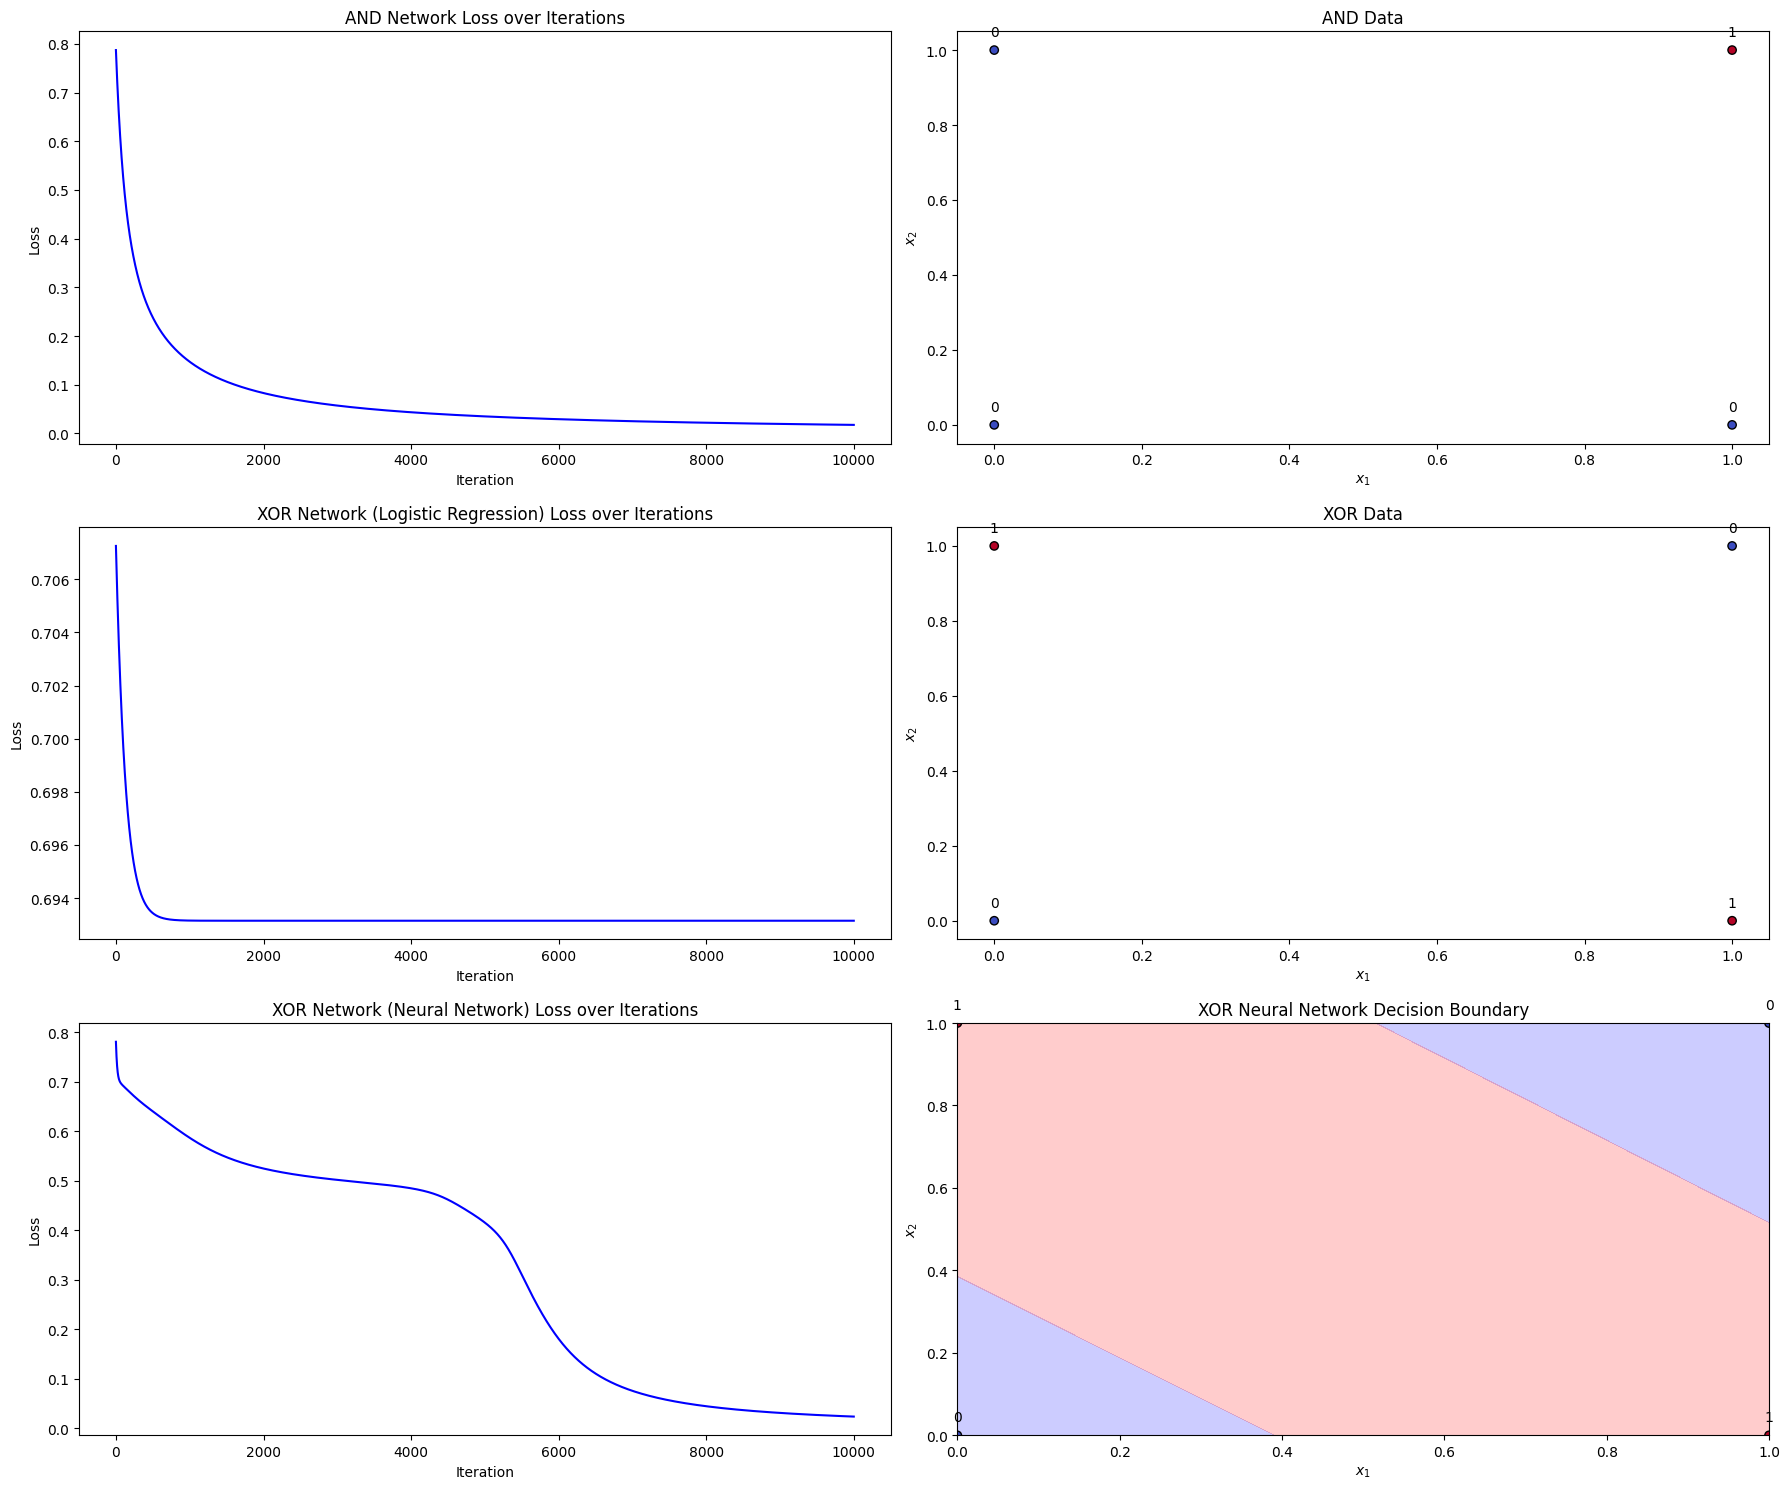

In [10]:
# 손실 및 데이터셋 플롯
fig, ax = plt.subplots(3, 2, figsize=(18, 15))

# AND 네트워크의 손실 변화를 플롯
ax[0, 0].plot(range(len(loss_history_and)), loss_history_and, color='blue')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_title('AND Network Loss over Iterations')

# AND 데이터셋 플롯
ax[0, 1].scatter(X_and[:, 0], X_and[:, 1], c=y_and.ravel(), edgecolors='k', marker='o', cmap='coolwarm')
for i, txt in enumerate(y_and.ravel()):
    ax[0, 1].annotate(txt, (X_and[i, 0], X_and[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
ax[0, 1].set_xlabel('$x_1$')
ax[0, 1].set_ylabel('$x_2$')
ax[0, 1].set_title('AND Data')

# 로지스틱 회귀로 XOR 네트워크의 손실 변화를 플롯
ax[1, 0].plot(range(len(loss_history_xor)), loss_history_xor, color='blue')
ax[1, 0].set_xlabel('Iteration')
ax[1, 0].set_ylabel('Loss')
ax[1, 0].set_title('XOR Network (Logistic Regression) Loss over Iterations')

# XOR 데이터셋 플롯
ax[1, 1].scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor.ravel(), edgecolors='k', marker='o', cmap='coolwarm')
for i, txt in enumerate(y_xor.ravel()):
    ax[1, 1].annotate(txt, (X_xor[i, 0], X_xor[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
ax[1, 1].set_xlabel('$x_1$')
ax[1, 1].set_ylabel('$x_2$')
ax[1, 1].set_title('XOR Data')

# 신경망으로 XOR 네트워크의 손실 변화를 플롯
ax[2, 0].plot(range(len(loss_history_xor_nn)), loss_history_xor_nn, color='blue')
ax[2, 0].set_xlabel('Iteration')
ax[2, 0].set_ylabel('Loss')
ax[2, 0].set_title('XOR Network (Neural Network) Loss over Iterations')

# 신경망 결정 경계 플롯
xx, yy = np.meshgrid(np.arange(0, 1.01, 0.01), np.arange(0, 1.01, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
preds = nn_xor.forward(grid)
preds = preds.reshape(xx.shape)
ax[2, 1].contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])
ax[2, 1].scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor.ravel(), edgecolors='k', marker='o', cmap='coolwarm')
for i, txt in enumerate(y_xor.ravel()):
    ax[2, 1].annotate(txt, (X_xor[i, 0], X_xor[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
ax[2, 1].set_xlabel('$x_1$')
ax[2, 1].set_ylabel('$x_2$')
ax[2, 1].set_title('XOR Neural Network Decision Boundary')

plt.tight_layout()
plt.show()

# MLP Comparison (NumPy vs Tensorflow)
- Tensorflow를 쓰는 이유 : GPU 연산!
- 모델의 성능 속도 비교

## Step 1. Create an MLP with numpy

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import time

# 데이터셋 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
y = y.reshape(-1, 1)  # y를 열 벡터로 변환
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 데이터셋을 학습용과 검증용으로 분할

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import time
import tensorflow as tf

# 데이터셋 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
y = y.reshape(-1, 1)  # y를 열 벡터로 변환
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 데이터셋을 학습용과 검증용으로 분할

# 단순 다층 퍼셉트론(MLP) 클래스 정의
class SimpleMLP:
    """
    단순 다층 퍼셉트론(MLP) 클래스

    매개변수:
    input_size (int): 입력층의 뉴런 수
    hidden_size (int): 은닉층의 뉴런 수
    output_size (int): 출력층의 뉴런 수

    메서드:
    forward(X): 순전파를 수행하여 출력값을 계산합니다.
    sigmoid(z): 시그모이드 활성화 함수를 적용합니다.
    compute_loss(y_true, y_pred): 이진 교차 엔트로피 손실을 계산합니다.
    backward(X, y, y_pred, learning_rate): 역전파를 수행하여 가중치와 바이어스를 업데이트합니다.
    train(X, y, X_val, y_val, learning_rate, n_iterations): 모델을 학습시키고 손실 히스토리를 반환합니다.
    """
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size)  # 입력층에서 은닉층으로의 가중치 초기화
        self.b1 = np.zeros(hidden_size)  # 은닉층의 바이어스 초기화
        self.W2 = np.random.randn(hidden_size, output_size)  # 은닉층에서 출력층으로의 가중치 초기화
        self.b2 = np.zeros(output_size)  # 출력층의 바이어스 초기화

        # Adam 옵티마이저를 위한 매개변수 초기화
        self.mW1, self.vW1 = np.zeros_like(self.W1), np.zeros_like(self.W1)
        self.mb1, self.vb1 = np.zeros_like(self.b1), np.zeros_like(self.b1)
        self.mW2, self.vW2 = np.zeros_like(self.W2), np.zeros_like(self.W2)
        self.mb2, self.vb2 = np.zeros_like(self.b2), np.zeros_like(self.b2)
        self.beta1, self.beta2 = 0.9, 0.999
        self.epsilon = 1e-8
        self.t = 0

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1  # 입력층에서 은닉층으로의 선형 변환
        self.A1 = self.sigmoid(self.Z1)  # 은닉층 활성화 함수 적용
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # 은닉층에서 출력층으로의 선형 변환
        self.A2 = self.sigmoid(self.Z2)  # 출력층 활성화 함수 적용
        return self.A2

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, X, y, y_pred, learning_rate):
        m = len(y)
        dZ2 = y_pred - y  # 출력층의 그래디언트 계산
        dW2 = np.dot(self.A1.T, dZ2) / m  # 은닉층에서 출력층으로의 가중치 그래디언트 계산
        db2 = np.sum(dZ2, axis=0) / m  # 출력층의 바이어스 그래디언트 계산
        dZ1 = np.dot(dZ2, self.W2.T) * self.A1 * (1 - self.A1)  # 은닉층의 그래디언트 계산
        dW1 = np.dot(X.T, dZ1) / m  # 입력층에서 은닉층으로의 가중치 그래디언트 계산
        db1 = np.sum(dZ1, axis=0) / m  # 은닉층의 바이어스 그래디언트 계산

        # Adam 옵티마이저를 사용한 가중치와 바이어스 업데이트
        self.t += 1  # 시간 스텝 증가
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dW1
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * (dW1 ** 2)
        mW1_hat = self.mW1 / (1 - self.beta1 ** self.t)
        vW1_hat = self.vW1 / (1 - self.beta2 ** self.t)
        self.W1 -= learning_rate * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)

        self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * db1
        self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * (db1 ** 2)
        mb1_hat = self.mb1 / (1 - self.beta1 ** self.t)
        vb1_hat = self.vb1 / (1 - self.beta2 ** self.t)
        self.b1 -= learning_rate * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)

        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dW2
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * (dW2 ** 2)
        mW2_hat = self.mW2 / (1 - self.beta1 ** self.t)
        vW2_hat = self.vW2 / (1 - self.beta2 ** self.t)
        self.W2 -= learning_rate * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)

        self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * db2
        self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * (db2 ** 2)
        mb2_hat = self.mb2 / (1 - self.beta1 ** self.t)
        vb2_hat = self.vb2 / (1 - self.beta2 ** self.t)
        self.b2 -= learning_rate * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)

    def train(self, X, y, X_val, y_val, learning_rate=0.001, n_iterations=10000):
        train_loss_history = []  # 학습 손실 히스토리
        val_loss_history = []  # 검증 손실 히스토리
        for iteration in range(n_iterations):
            y_pred = self.forward(X)  # 순전파 수행
            train_loss = self.compute_loss(y, y_pred)  # 학습 손실 계산
            train_loss_history.append(train_loss)  # 학습 손실 히스토리 기록
            self.backward(X, y, y_pred, learning_rate)  # 역전파 수행

            y_val_pred = self.forward(X_val)  # 검증 데이터에 대한 예측 수행
            val_loss = self.compute_loss(y_val, y_val_pred)  # 검증 손실 계산
            val_loss_history.append(val_loss)  # 검증 손실 히스토리 기록
        return train_loss_history, val_loss_history

# Numpy MLP 학습 및 시간 측정
mlp_numpy = SimpleMLP(input_size=2, hidden_size=5, output_size=1)

start_time_numpy = time.time()
train_loss_history_numpy, val_loss_history_numpy = mlp_numpy.train(X_train, y_train, X_val, y_val, learning_rate=0.001, n_iterations=1000)

time_numpy = time.time() - start_time_numpy  # 학습 시간 계산

## Step 2. Tensorflow


In [13]:
import tensorflow as tf

# TensorFlow 모델 생성 및 컴파일
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(2,)),  # 첫 번째 은닉층, 뉴런 수를 증가하고 ReLU 활성화 함수 사용
    tf.keras.layers.Dense(10, activation='relu'),  # 두 번째 은닉층 추가
    tf.keras.layers.Dense(5, activation='relu'),  # 세 번째 은닉층 추가
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층
])
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 모델 컴파일

# TensorFlow 모델 학습 시간 측정
start_time_tf = time.time()
history_tf = model_tf.fit(X_train, y_train, epochs=10000, validation_data=(X_val, y_val), verbose=0)  # 모델 학습
time_tf = time.time() - start_time_tf  # 학습 시간 계산

# 학습 시간 출력
print(f"Training time (Numpy MLP): {time_numpy:.2f} seconds")
print(f"Training time (TensorFlow MLP): {time_tf:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training time (Numpy MLP): 0.28 seconds
Training time (TensorFlow MLP): 4.01 seconds


## Step 3. Plot the training and validation loss

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 998us/step


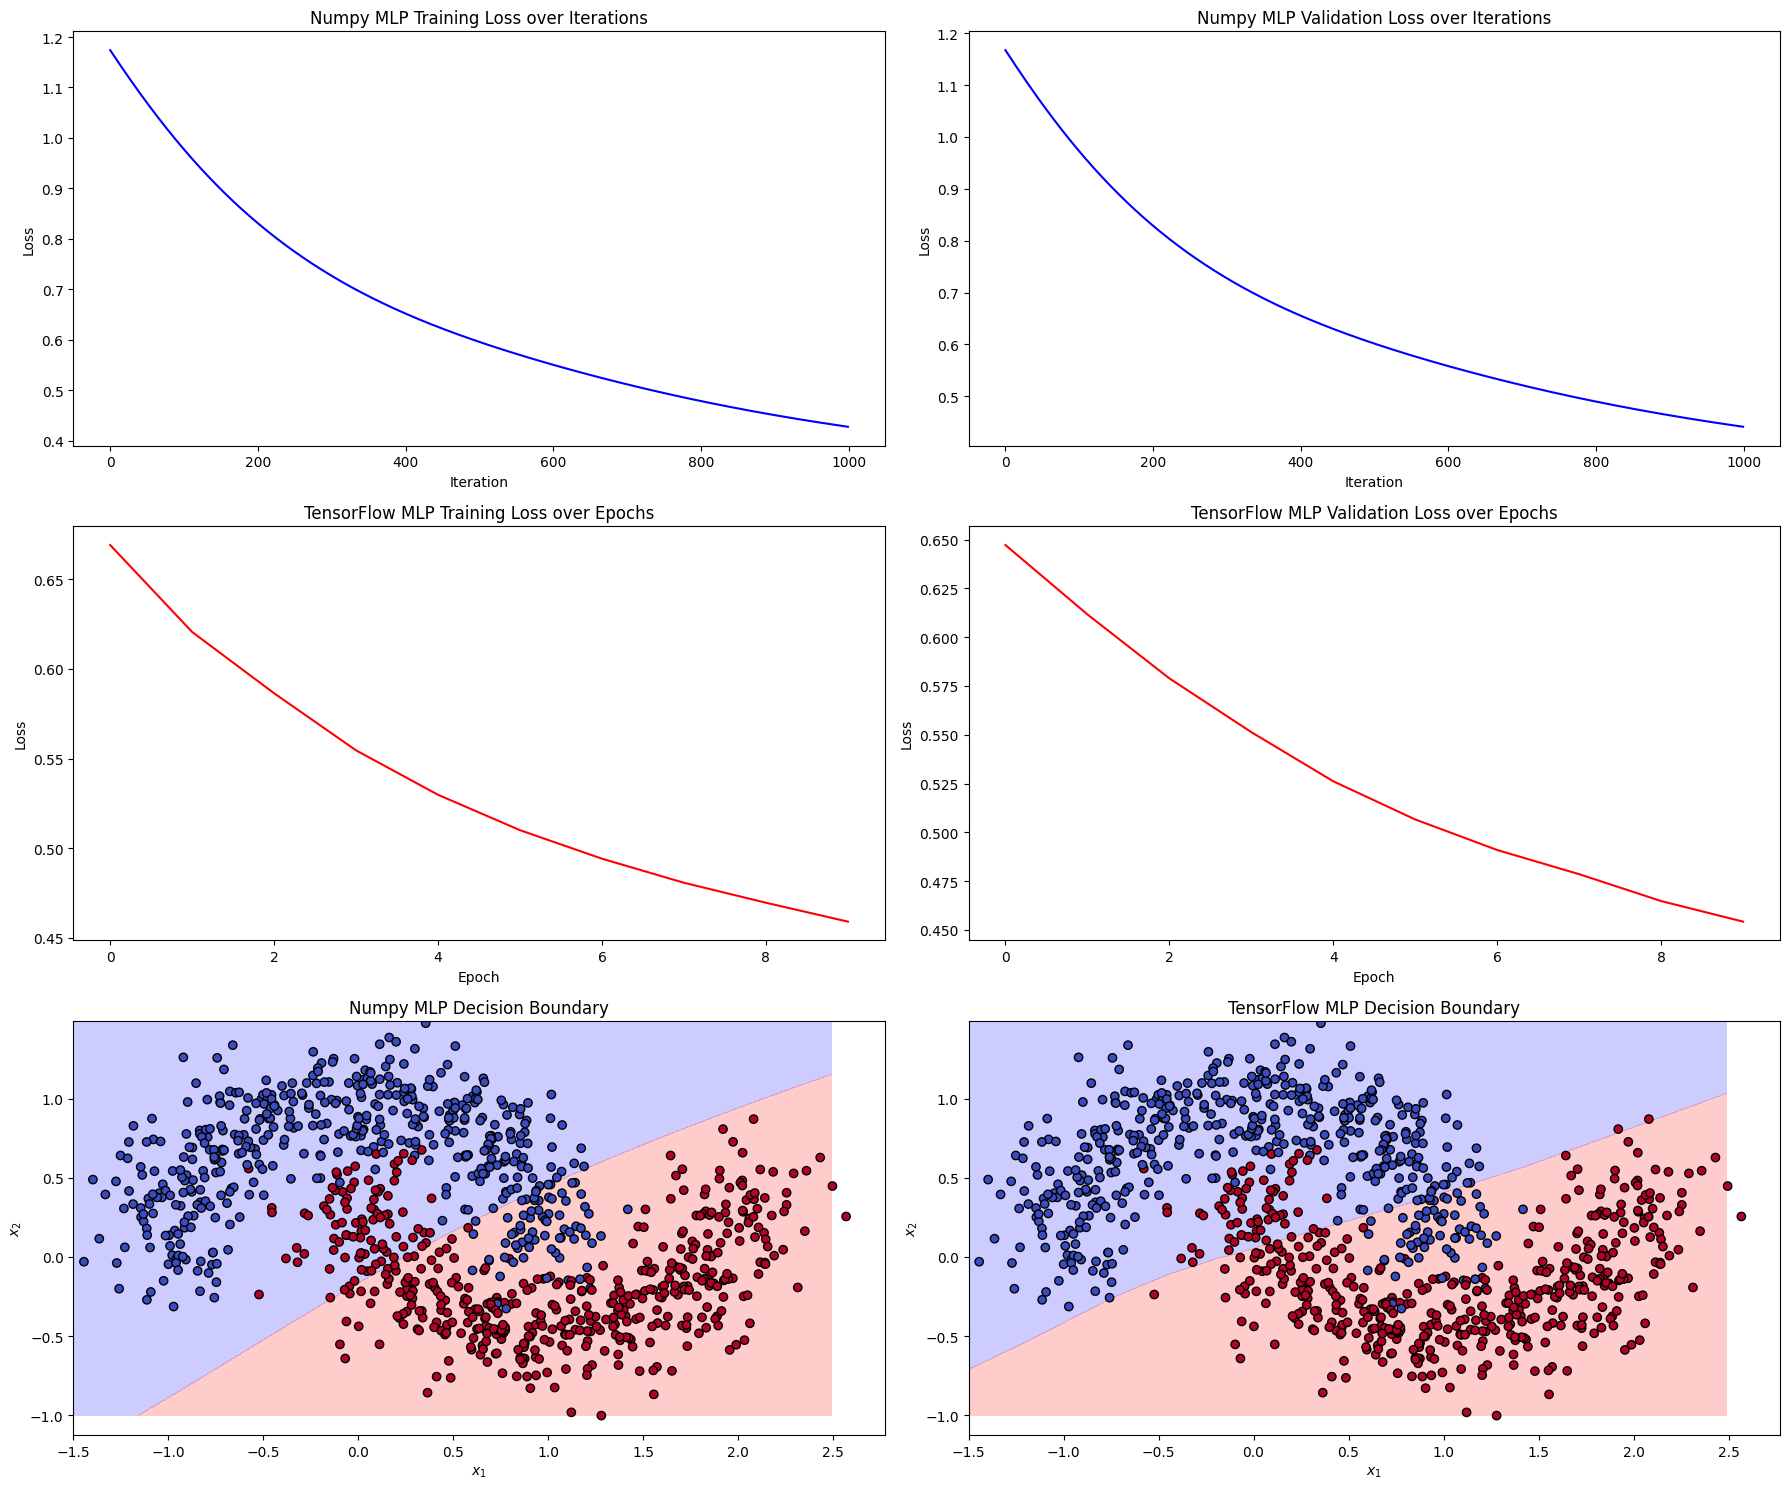

In [14]:
# 두 모델의 반복에 따른 손실을 플롯팅
fig, ax = plt.subplots(3, 2, figsize=(18, 15))

# Numpy MLP의 학습 손실 플롯
ax[0, 0].plot(range(len(train_loss_history_numpy)), train_loss_history_numpy, color='blue')
ax[0, 0].set_xlabel('Iteration')  # x축 레이블 설정
ax[0, 0].set_ylabel('Loss')  # y축 레이블 설정
ax[0, 0].set_title('Numpy MLP Training Loss over Iterations')  # 플롯 제목 설정

# Numpy MLP의 검증 손실 플롯
ax[0, 1].plot(range(len(val_loss_history_numpy)), val_loss_history_numpy, color='blue')
ax[0, 1].set_xlabel('Iteration')  # x축 레이블 설정
ax[0, 1].set_ylabel('Loss')  # y축 레이블 설정
ax[0, 1].set_title('Numpy MLP Validation Loss over Iterations')  # 플롯 제목 설정

# TensorFlow MLP의 학습 손실 플롯
ax[1, 0].plot(history_tf.history['loss'], color='red')
ax[1, 0].set_xlabel('Epoch')  # x축 레이블 설정
ax[1, 0].set_ylabel('Loss')  # y축 레이블 설정
ax[1, 0].set_title('TensorFlow MLP Training Loss over Epochs')  # 플롯 제목 설정

# TensorFlow MLP의 검증 손실 플롯
ax[1, 1].plot(history_tf.history['val_loss'], color='red')
ax[1, 1].set_xlabel('Epoch')  # x축 레이블 설정
ax[1, 1].set_ylabel('Loss')  # y축 레이블 설정
ax[1, 1].set_title('TensorFlow MLP Validation Loss over Epochs')  # 플롯 제목 설정

# Numpy MLP의 결정 경계 플롯
xx, yy = np.meshgrid(np.arange(-1.5, 2.5, 0.01), np.arange(-1, 1.5, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
preds_numpy = mlp_numpy.forward(grid)  # Numpy MLP로 예측 수행
preds_numpy = preds_numpy.reshape(xx.shape)
ax[2, 0].contourf(xx, yy, preds_numpy, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])  # 결정 경계 플롯
ax[2, 0].scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', cmap='coolwarm')  # 데이터 포인트 플롯
ax[2, 0].set_xlabel('$x_1$')  # x축 레이블 설정
ax[2, 0].set_ylabel('$x_2$')  # y축 레이블 설정
ax[2, 0].set_title('Numpy MLP Decision Boundary')  # 플롯 제목 설정

# TensorFlow MLP의 결정 경계 플롯
preds_tf = model_tf.predict(grid).reshape(xx.shape)  # TensorFlow MLP로 예측 수행
ax[2, 1].contourf(xx, yy, preds_tf, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])  # 결정 경계 플롯
ax[2, 1].scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', cmap='coolwarm')  # 데이터 포인트 플롯
ax[2, 1].set_xlabel('$x_1$')  # x축 레이블 설정
ax[2, 1].set_ylabel('$x_2$')  # y축 레이블 설정
ax[2, 1].set_title('TensorFlow MLP Decision Boundary')  # 플롯 제목 설정

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 플롯 표시

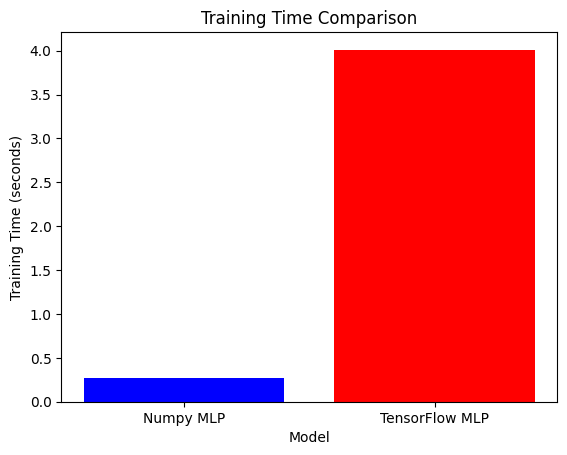

In [15]:
# 모델 학습 시간 비교 바 플롯
fig, ax = plt.subplots()

ax.bar(['Numpy MLP', 'TensorFlow MLP'], [time_numpy, time_tf], color=['blue', 'red'])  # 바 플롯 생성
ax.set_xlabel('Model')  # x축 레이블 설정
ax.set_ylabel('Training Time (seconds)')  # y축 레이블 설정
ax.set_title('Training Time Comparison')  # 플롯 제목 설정

plt.show()

# Tensorflow ML

In [16]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Iris 데이터셋 로드
df = sns.load_dataset('iris')

# 데이터 전처리
X = df.drop(columns='species')  # 'species' 열을 제외한 나머지 데이터를 입력 데이터로 사용
y = df['species']  # 'species' 열을 출력 데이터로 사용

# 타겟 변수 인코딩
encoder = LabelEncoder()  # LabelEncoder 객체 생성
y_encoded = encoder.fit_transform(y)  # 타겟 변수 인코딩

# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)  # 학습용 80%, 테스트용 20%로 분할

# 데이터 표준화
scaler = StandardScaler()  # StandardScaler 객체 생성
X_train_scaled = scaler.fit_transform(X_train)  # 학습 데이터 표준화
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터 표준화

# TensorFlow 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # 첫 번째 은닉층, 입력 차원은 학습 데이터의 특징 수
    tf.keras.layers.Dense(64, activation='relu'),  # 두 번째 은닉층
    tf.keras.layers.Dense(3, activation='softmax')  # 출력층, 세 가지 클래스에 대한 확률 출력
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adam 옵티마이저와 sparse_categorical_crossentropy 손실 함수 사용

# 모델 학습
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=1)  # 학습 데이터의 80%를 학습용, 20%를 검증용으로 사용하여 모델 학습

# 모델 평가
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)  # 테스트 데이터로 모델 평가
print(f'Accuracy on Test Set: {accuracy}')  # 테스트 세트에서의 정확도 출력

# 모델 예측
y_pred = model.predict(X_test_scaled)  # 테스트 데이터에 대한 예측 수행
y_pred_classes = y_pred.argmax(axis=1)  # 예측 확률을 클래스 레이블로 변환

# 예측 결과를 DataFrame으로 변환하여 비교
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes})  # 실제 값과 예측 값을 DataFrame으로 생성
print(predictions.head())  # 첫 다섯 개의 예측 결과 출력

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 672ms/step - accuracy: 0.3854 - loss: 1.1293 - val_accuracy: 0.3750 - val_loss: 1.1123
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5690 - loss: 1.0208 - val_accuracy: 0.5833 - val_loss: 1.0177
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7448 - loss: 0.9355 - val_accuracy: 0.8333 - val_loss: 0.9331
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8320 - loss: 0.8704 - val_accuracy: 0.8750 - val_loss: 0.8588
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7891 - loss: 0.8028 - val_accuracy: 0.8750 - val_loss: 0.7951
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8242 - loss: 0.7338 - val_accuracy: 0.8750 - val_loss: 0.7375
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8164 - loss: 0.6725 - val_accuracy: 0.8750 - val_loss: 0.6872
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7839 - loss: 0.6616 - val_accuracy: 0.8750 - val_loss: 0.6424
Epo

   Actual  Predicted
0       1          1
1       0          0
2       2          2
3       1          1
4       1          1


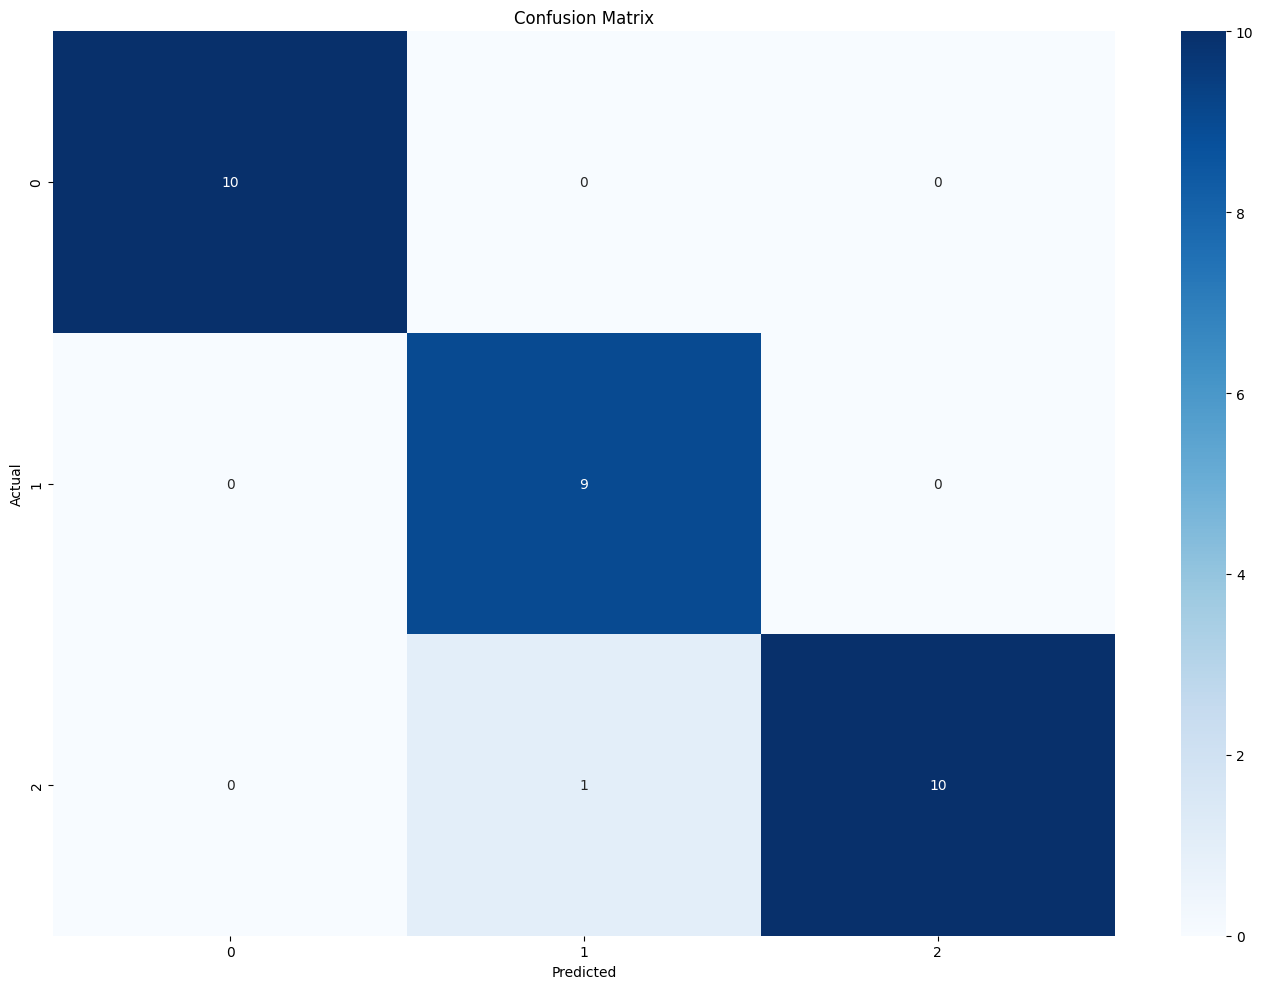

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 예측 결과를 DataFrame으로 변환하여 비교하기 쉽게 함
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes})
print(predictions.head())  # 첫 다섯 개의 실제 값과 예측 값을 출력

# 비교 및 혼동 행렬 시각화
fig, ax = plt.subplots(figsize=(14, 10))  # 그림과 축 객체를 생성, 크기는 14x10 인치로 설정
# 혼동 행렬 계산 및 플롯
cm = confusion_matrix(y_test, y_pred_classes)  # 실제 값과 예측 값을 사용하여 혼동 행렬 계산
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 시각화, 각 셀에 값 표시, 블루 색상 맵 사용
ax.set_title('Confusion Matrix')  # 플롯 제목 설정
ax.set_xlabel('Predicted')  # x축 레이블 설정
ax.set_ylabel('Actual')  # y축 레이블 설정

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 플롯 표시


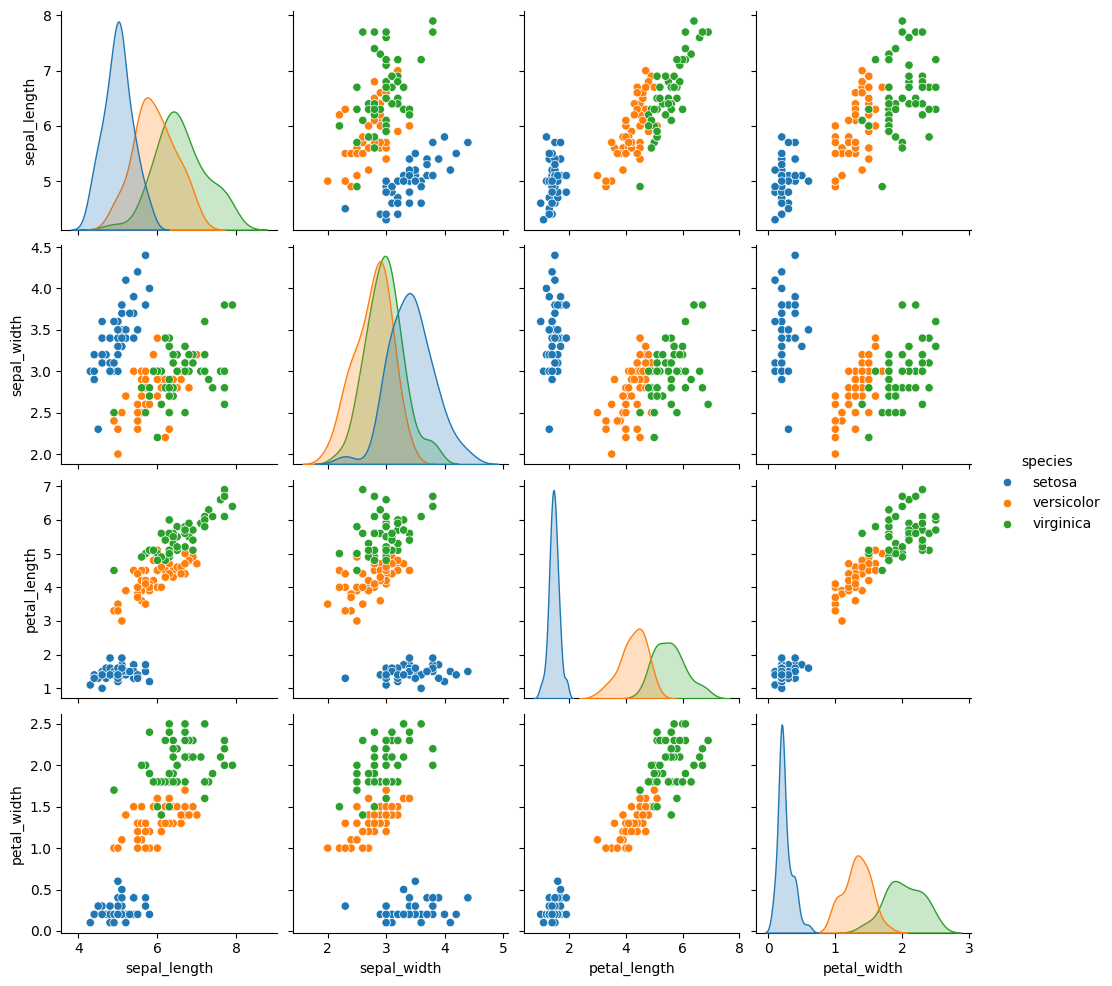

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 상관계수
sns.pairplot(df, hue='species')

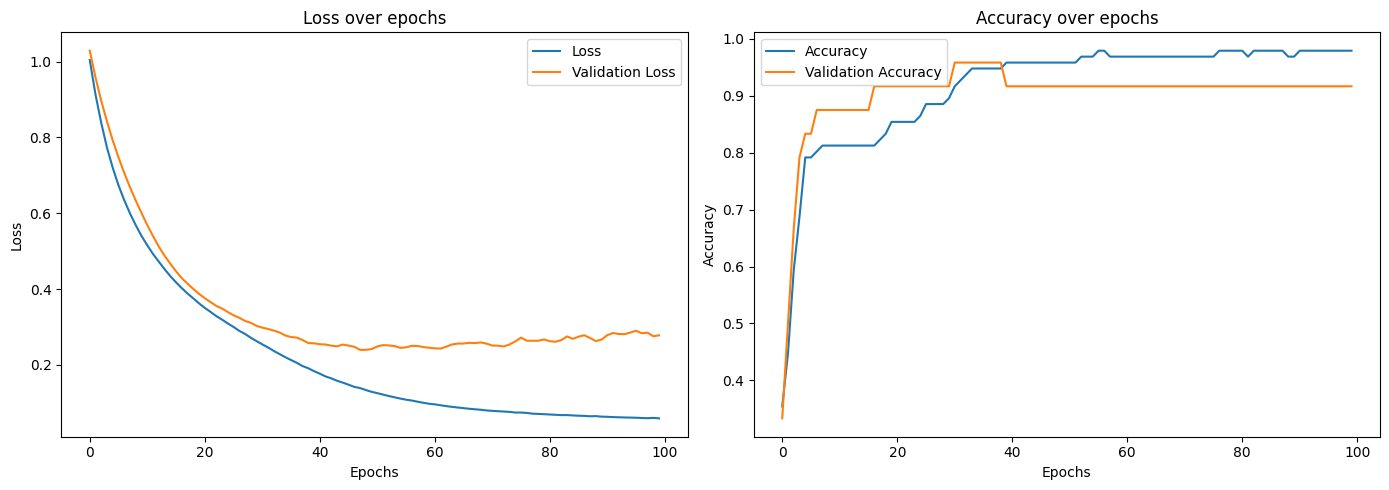

In [ ]:
# 손실과 정확도 플롯을 위한 서브플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 에포크에 따른 손실 플롯
ax[0].plot(history.history['loss'], label='Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# 에포크에 따른 정확도 플롯
ax[1].plot(history.history['accuracy'], label='Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()